   Unnamed: 0  Zaman  Maxell     GP  Fujitsu  Duracell
0         NaN    0.0   3.307  3.301    3.287     3.238
1         NaN    0.0   3.307  3.301    3.287     3.238
2         NaN    1.0   3.307  3.301    3.287     3.240
3         NaN    3.0   3.112  3.035    3.091     3.071
4         NaN    5.0   3.066  3.015    3.051     3.039
Unnamed: 0    6370
Zaman          315
Maxell         317
GP             315
Fujitsu          0
Duracell       372
dtype: int64
Number of rows remaining: 6370
Zaman       315
Maxell      317
GP          315
Fujitsu       0
Duracell    372
dtype: int64
Number of rows remaining: (6370, 5)
      Zaman  Maxell     GP  Fujitsu  Duracell
0       0.0   3.307  3.301    3.287     3.238
1       0.0   3.307  3.301    3.287     3.238
2       1.0   3.307  3.301    3.287     3.240
3       3.0   3.112  3.035    3.091     3.071
4       5.0   3.066  3.015    3.051     3.039
...     ...     ...    ...      ...       ...
6365    NaN     NaN    NaN    1.804       NaN
6366    NaN    

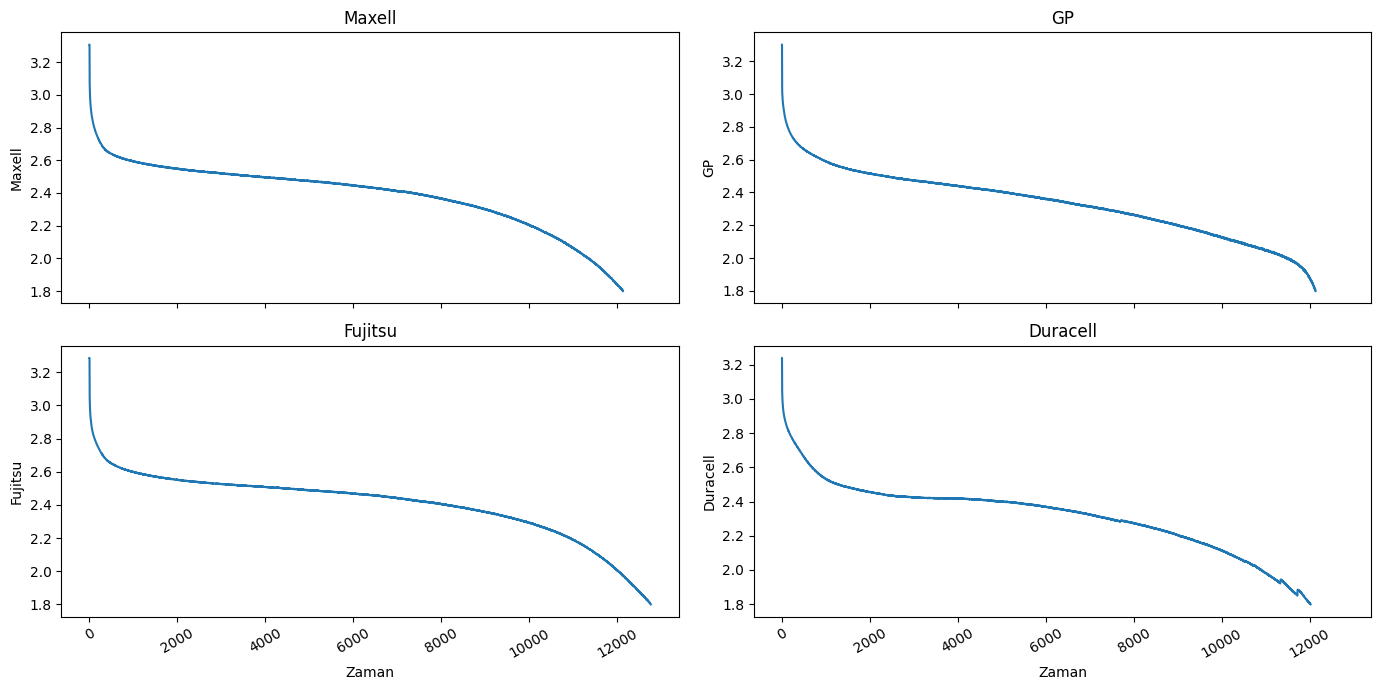

Number of NaN values: 0


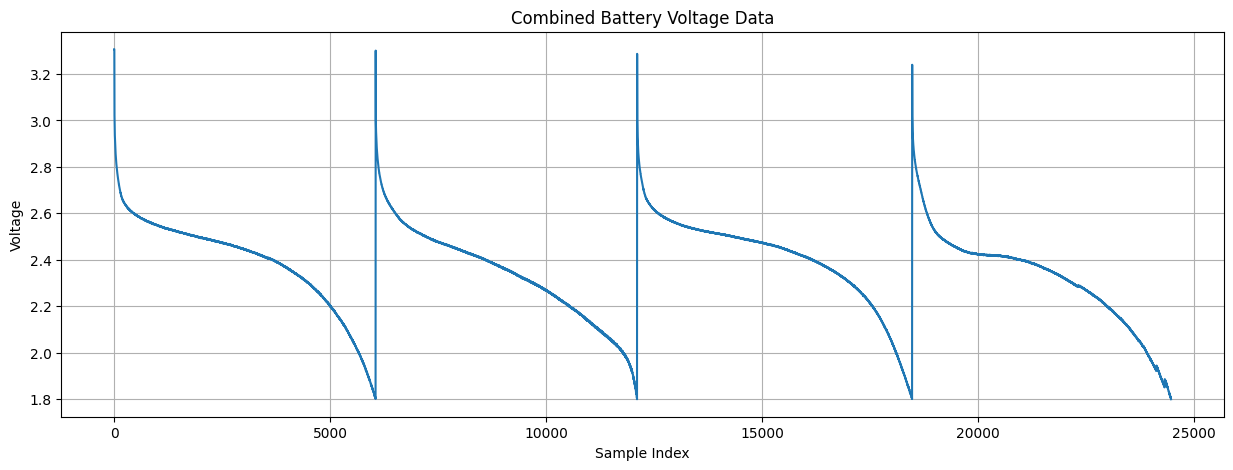

[1.         1.         1.         0.87068966 0.84018568]
[0.32360743 0.32228117 0.32228117 0.32228117 0.32360743]
[0.40384615 0.40318302 0.40384615 0.40450928 0.40384615]


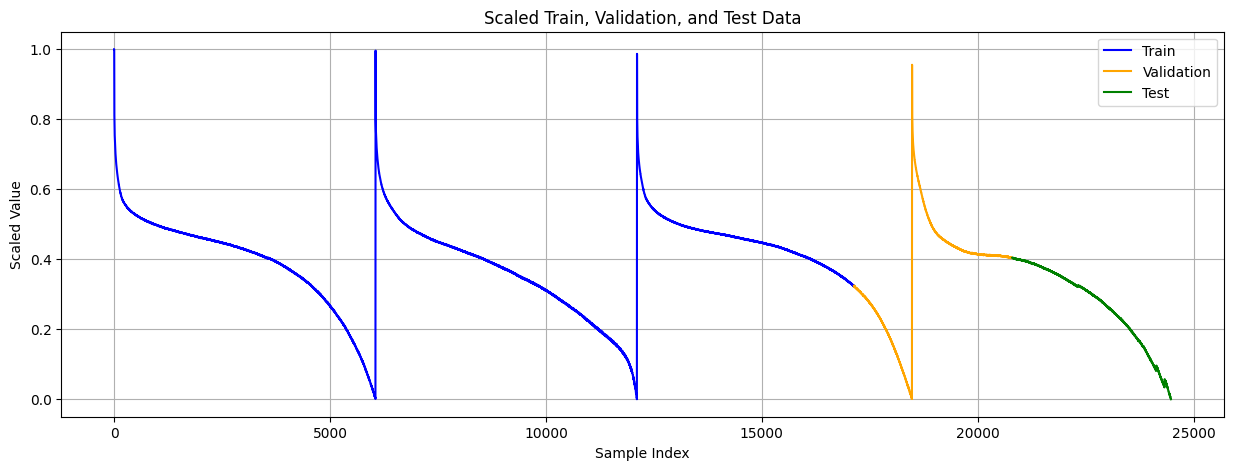

torch.Size([17066, 67]) torch.Size([17066])
torch.Size([3604, 67]) torch.Size([3604])
torch.Size([3605, 67]) torch.Size([3605])
Batch x shape: torch.Size([32, 67])
Batch y shape: torch.Size([32])


In [1]:
%run DatasetUpload.ipynb

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [3]:

PATH = 'CNN_model.pth'  # Path to the saved weights
model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

# Set the model to evaluation mode
model.eval()

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): CNN(
    (layer1): ResBlock(
      (conv): Sequential(
        (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_connection): Sequential(
        (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (layer2): ResBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): CNN(
    (layer1): ResBlock(
      (conv): Sequential(
        (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (skip_connection): Sequential(
        (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (layer2): ResBlock(
      (conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size

In [7]:
def calculate_metrics_sklearn(y_true, y_pred):
    """Calculate R², MAE, MSE, and MAPE using sklearn metrics."""
    # R²
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    # mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Multiply by 100 to get percentage

    return r2, mae, mse

def Train(model, train_loader, valid_loader, test_loader, args, save_folder=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Ensure the model is on the correct device

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    # Define loss function
    mse_loss = torch.nn.MSELoss()

    min_loss = 10
    stop = 0
    train_losses = []
    valid_losses = []
    best_state = None

    # Store metrics for train, validation, and test
    train_r2_values = []
    valid_r2_values = []

    for e in range(1, args.n_epoch + 1):
        # --------- Train one epoch manually ---------
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(pred.cpu().detach().numpy())
            all_train_labels.append(label.cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Calculate metrics for training
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
        train_r2, train_mae,train_mse = calculate_metrics_sklearn(all_train_labels, all_train_preds)
        train_r2_values.append(train_r2)

        scheduler.step()

        # --------- Validation manually ---------
        model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                label = label.unsqueeze(1)
                pred = model(data)
                loss = mse_loss(pred, label)
                valid_loss += loss.item()

                all_valid_preds.append(pred.cpu().detach().numpy())
                all_valid_labels.append(label.cpu().detach().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Calculate metrics for validation
        all_valid_preds = np.concatenate(all_valid_preds, axis=0)
        all_valid_labels = np.concatenate(all_valid_labels, axis=0)
        valid_r2, valid_mae, valid_mse = calculate_metrics_sklearn(all_valid_labels, all_valid_preds)
        valid_r2_values.append(valid_r2)

        lr = optimizer.state_dict()['param_groups'][0]['lr']
        
        # Print each epoch's training and validation results
        print(f"Epoch [{e}/{args.n_epoch}] - Train Loss: {train_loss:.5f} | Train R²: {train_r2:.5f} | Train MAE: {train_mae:.5f} | Train MSE: {train_mse:.5f}")
        print(f"             - Valid Loss: {valid_loss:.5f} | Valid R²: {valid_r2:.5f} | Valid MAE: {valid_mae:.5f} | Valid MSE: {valid_mse:.5f}")
    
        
        if e % 10 == 0:
            print()  # Newline every 10 epochs for clarity

        # --------- Save best model ---------
        if valid_loss < min_loss:
            best_state = model.state_dict()
            min_loss = valid_loss
            stop = 0
        else: stop += 1
        # --------- Early stopping ---------
        if stop >= args.early_stop:
            print("\nEarly stopping triggered.")
            break

    # --------- After all epochs, evaluate on test set ---------
    test_loss = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)
            test_loss += loss.item()

            all_test_preds.append(pred.cpu().detach().numpy())
            all_test_labels.append(label.cpu().detach().numpy())

    test_loss /= len(test_loader)

    # Flatten the predictions and labels for metric calculations
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Calculate metrics for test set
    test_r2, test_mae, test_mse = calculate_metrics_sklearn(all_test_labels, all_test_preds)

    # Print test results at the end of training
    print(f"Final Test Loss: {test_loss:.5f}, Test R²: {test_r2:.5f}, Test MAE: {test_mae:.5f}, Test MSE: {test_mse:.5f}")

    # --------- Save model ---------
    # if save_folder is not None and best_state is not None:
    #     torch.save(best_state, save_folder + '/best_model.pth')

    return train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds


In [8]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00617 | Train R²: 0.59510 | Train MAE: 0.02080 | Train MSE: 0.00618
             - Valid Loss: 0.02434 | Valid R²: -0.03248 | Valid MAE: 0.13313 | Valid MSE: 0.02439
Epoch [2/100] - Train Loss: 0.01052 | Train R²: 0.30969 | Train MAE: 0.04360 | Train MSE: 0.01053
             - Valid Loss: 0.01695 | Valid R²: 0.28068 | Valid MAE: 0.10902 | Valid MSE: 0.01700
Epoch [3/100] - Train Loss: 0.01168 | Train R²: 0.23376 | Train MAE: 0.05352 | Train MSE: 0.01169
             - Valid Loss: 0.01456 | Valid R²: 0.38176 | Valid MAE: 0.09929 | Valid MSE: 0.01461
Epoch [4/100] - Train Loss: 0.01179 | Train R²: 0.22629 | Train MAE: 0.05593 | Train MSE: 0.01180
             - Valid Loss: 0.01398 | Valid R²: 0.40668 | Valid MAE: 0.09752 | Valid MSE: 0.01402
Epoch [5/100] - Train Loss: 0.00892 | Train R²: 0.41440 | Train MAE: 0.04072 | Train MSE: 0.00893
             - Valid Loss: 0.01190 | Valid R²: 0.49541 | Valid MAE: 0.08950 | Valid MSE: 0.01192
Epoch [6/100] - Train Lo

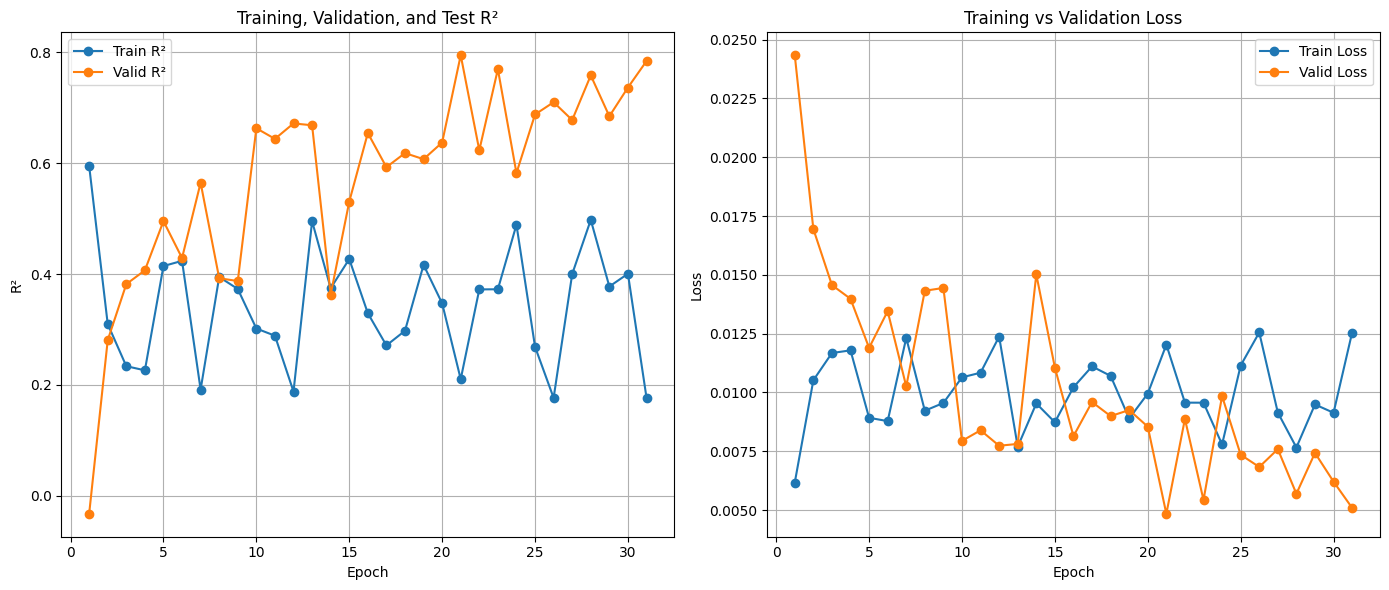

In [9]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
for name, param in model.named_parameters():
    if 'predictor' not in name:  # This checks if the parameter is not in the 'predictor' layer
        param.requires_grad = False
    else:
        param.requires_grad = True  # Allow the last layer to be trainable

In [11]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00692 | Train R²: 0.54593 | Train MAE: 0.05612 | Train MSE: 0.00693
             - Valid Loss: 0.00457 | Valid R²: 0.80589 | Valid MAE: 0.04234 | Valid MSE: 0.00459
Epoch [2/100] - Train Loss: 0.00733 | Train R²: 0.51946 | Train MAE: 0.05947 | Train MSE: 0.00733
             - Valid Loss: 0.00468 | Valid R²: 0.80147 | Valid MAE: 0.04707 | Valid MSE: 0.00469
Epoch [3/100] - Train Loss: 0.00709 | Train R²: 0.53528 | Train MAE: 0.05832 | Train MSE: 0.00709
             - Valid Loss: 0.00470 | Valid R²: 0.80066 | Valid MAE: 0.04790 | Valid MSE: 0.00471
Epoch [4/100] - Train Loss: 0.00703 | Train R²: 0.53914 | Train MAE: 0.05867 | Train MSE: 0.00703
             - Valid Loss: 0.00481 | Valid R²: 0.79619 | Valid MAE: 0.04977 | Valid MSE: 0.00482
Epoch [5/100] - Train Loss: 0.00672 | Train R²: 0.55962 | Train MAE: 0.05663 | Train MSE: 0.00672
             - Valid Loss: 0.00458 | Valid R²: 0.80558 | Valid MAE: 0.04581 | Valid MSE: 0.00459
Epoch [6/100] - Train Los

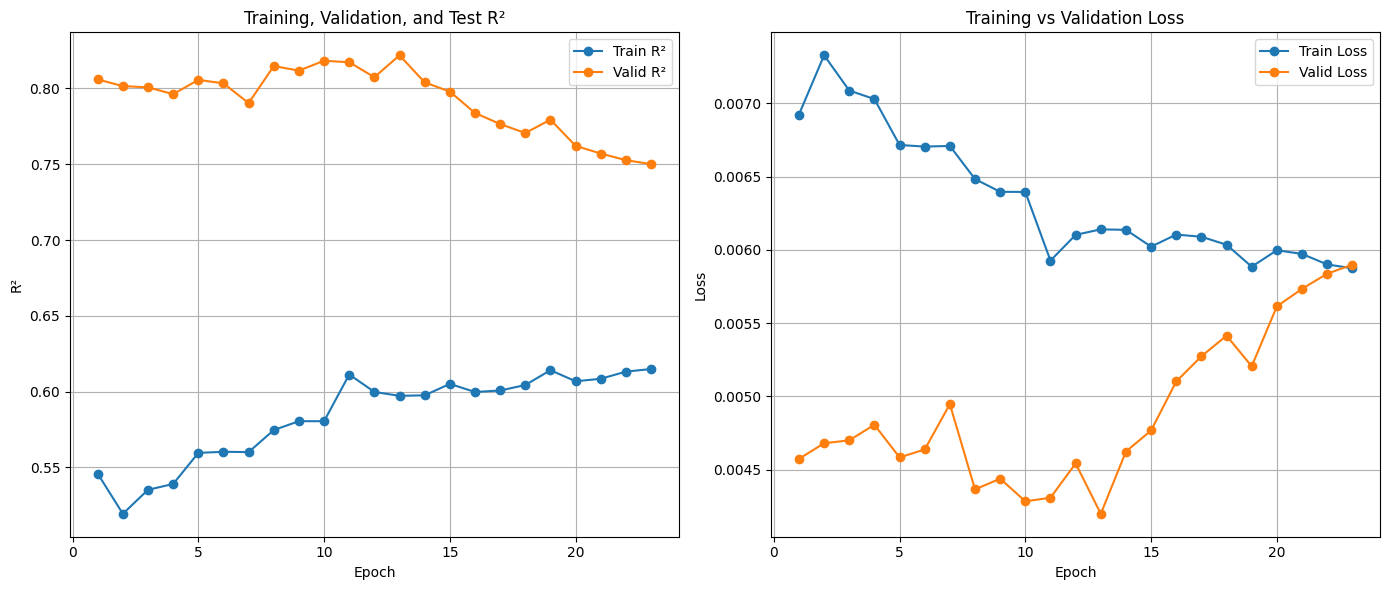

In [12]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer {name} is not frozen.")
    else:
        print(f"Layer {name} is frozen.")

Layer pre_net.weight is frozen.
Layer pre_net.bias is frozen.
Layer backbone.layer1.conv.0.weight is frozen.
Layer backbone.layer1.conv.0.bias is frozen.
Layer backbone.layer1.conv.1.weight is frozen.
Layer backbone.layer1.conv.1.bias is frozen.
Layer backbone.layer1.conv.3.weight is frozen.
Layer backbone.layer1.conv.3.bias is frozen.
Layer backbone.layer1.conv.4.weight is frozen.
Layer backbone.layer1.conv.4.bias is frozen.
Layer backbone.layer1.skip_connection.0.weight is frozen.
Layer backbone.layer1.skip_connection.0.bias is frozen.
Layer backbone.layer1.skip_connection.1.weight is frozen.
Layer backbone.layer1.skip_connection.1.bias is frozen.
Layer backbone.layer2.conv.0.weight is frozen.
Layer backbone.layer2.conv.0.bias is frozen.
Layer backbone.layer2.conv.1.weight is frozen.
Layer backbone.layer2.conv.1.bias is frozen.
Layer backbone.layer2.conv.3.weight is frozen.
Layer backbone.layer2.conv.3.bias is frozen.
Layer backbone.layer2.conv.4.weight is frozen.
Layer backbone.laye

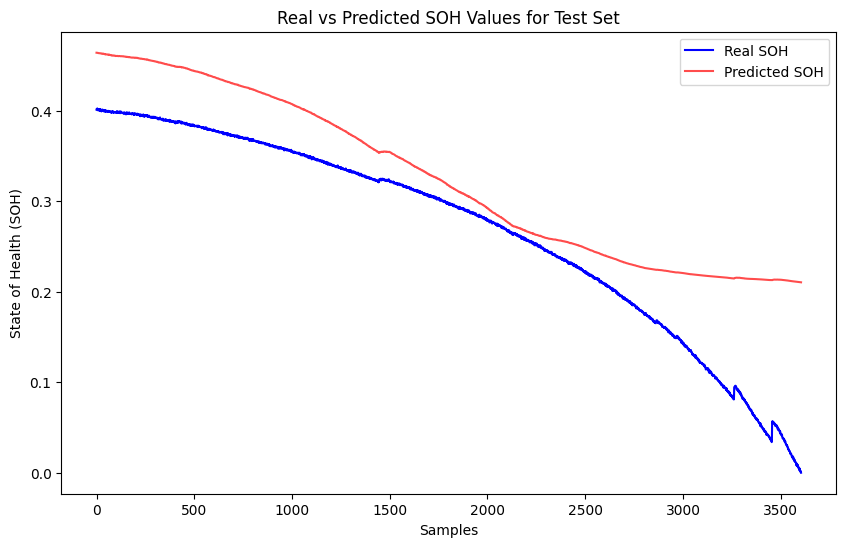

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(all_test_labels, label="Real SOH", color='blue')
plt.plot(all_test_preds, label="Predicted SOH", color='red', alpha=0.7)
plt.title('Real vs Predicted SOH Values for Test Set')
plt.xlabel('Samples')
plt.ylabel('State of Health (SOH)')
plt.legend()
plt.show()

cnn works better with freezing layers

Freezing layers reduces the number of trainable parameters, which is especially helpful when the new dataset is small.

Faster Training
